# CS-141 HW2

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import cv2

# Autosave work 
%load_ext autoreload
%autoreload 2
%autosave 180

Autosaving every 180 seconds



 The range in the x and y directions is (12,9) units 


 The initial position vector x = [ 7 -2] 



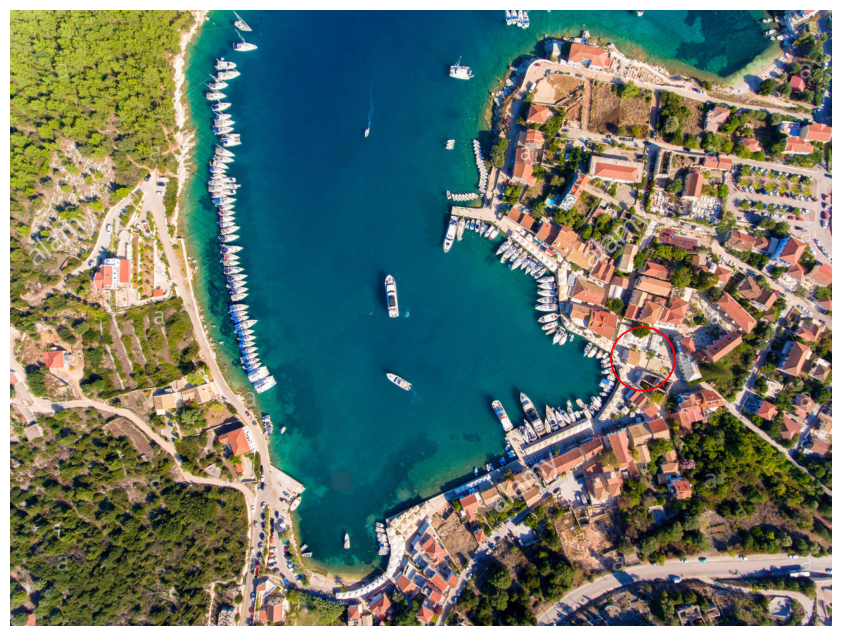

In [29]:
# Upload image of choice 
map = cv2.imread('BayMap.png')
map = cv2.cvtColor(map, cv2.COLOR_BGR2RGB)
# map = cv2.imread('CityMap.png')
# map = cv2.imread('MarioMap.png')

# Constants
m = 100  # images mxm pixels
dFOV = 50  # Field of view of the drone
sigma_movement = 5  # Movement from wind

# Calculate the range in the x and y directions
range_x = ((map.shape[1] - dFOV) // 2) // 50
range_y = ((map.shape[0] - dFOV) // 2) // 50
print(f'\n The range in the x and y directions is ({range_x},{range_y}) units \n')

# Simulate a drone's starting position x and y
pos_x = np.random.randint(-range_x, range_x + 1)
pos_y = np.random.randint(-range_y, range_y + 1)

state_ini = np.array([[pos_x], [pos_y]])
print(f'\n The initial position vector x = {state_ini.flatten()} \n')

# Convert unit position to pixel coordinates
center_x = int((pos_x) * 50 + (map.shape[1] // 2))
center_y = int((range_y - pos_y) * 50)

# Draw a circle with radius 50 pixels (1 unit)
radius_pixels = 50  # 1 unit = 50 pixels
cv2.circle(map, (center_x, center_y), radius_pixels, (255, 0, 0), 2)  # Red circle

# Show the image
plt.figure(figsize=(15, 8))
plt.imshow(map)
plt.axis("off")
plt.show()


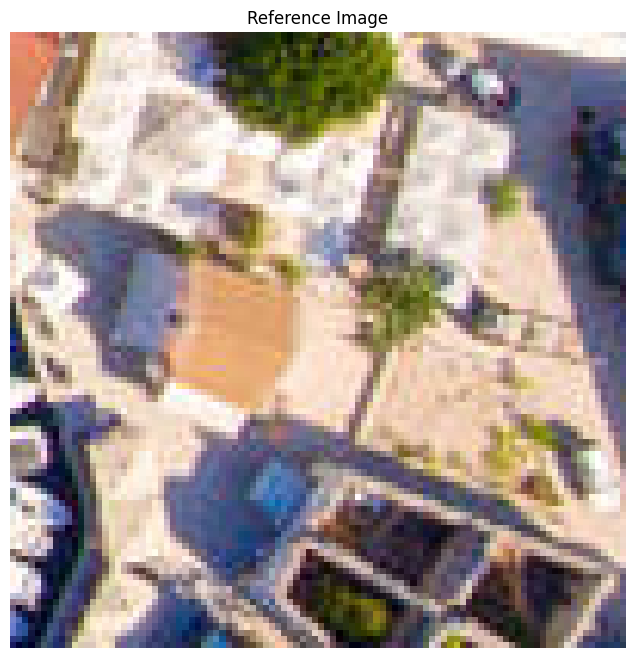

In [30]:
# Initial Pose 
# Re-initialize map
map = cv2.imread('BayMap.png')
map = cv2.cvtColor(map, cv2.COLOR_BGR2RGB)
hal = int(m/2)
ini_pos = map[center_y-hal:center_y+hal, center_x-hal:center_x+hal] #, height_s:height_e]

# Show the true position image
plt.figure(figsize=(15, 8))
plt.imshow(ini_pos)
plt.title("Reference Image")
plt.axis("off")
plt.show()

In [31]:
# Functions that can move the drone and particles
# Generate random movement in the x and y direction

def random_movement():
    """ Generates a random movement vector in the x and y direction, 
    such that dx^2 + dy^2 = 1.0
    Inputs: none
    Outputs: dx, dy
    """
    dx = np.random.uniform(-1, 1)
    posneg = np.random.choice([-1, 1])
    dy = (np.sqrt(1-dx**2))*posneg
    return dx,dy

def move_drone(pos,map, sigma_movement = 5):
    """ 
    Moves the drone a random distance dx, dy
    while checking to make sure it is in range of the map
    Inputs: Previous position, map
    OUtputs: new position 
    """
    dx,dy = random_movement()
    # print(dx)
    # print(dy)
    move_x = int(np.floor(dx*50)) + np.random.randn()*sigma_movement
    move_y = int(np.floor(dy*50)) + np.random.randn()*sigma_movement
    new_pos = pos + np.array([[move_x],[move_y]])

    while new_pos[0] > (map.shape[1]) or new_pos[1] > (map.shape[0]) or new_pos[0] < (0) or new_pos[1] < (0):
        print("Movement rejected, generating a new movement")
        dx,dy = random_movement()
        move_x = int(np.floor(dx*50)) + sigma_movement
        move_y = int(np.floor(dy*50)) + sigma_movement
        new_pos = pos + np.array([[move_x],[move_y]])
        # print(new_pos)

    return new_pos,dx,dy

def move_particle(pos,map, dx, dy):
    """ 
    Moves the drone a random distance dx, dy
    while checking to make sure it is in range of the map
    Inputs: Previous position, map
    OUtputs: new position 
    """
    move_x = int(np.floor(dx*50))
    # print(move_x)
    move_y = int(np.floor(dy*50))
    # print(move_y)
    new_pos = pos + np.array([[move_x],[move_y]])


    return new_pos

(225, 3)


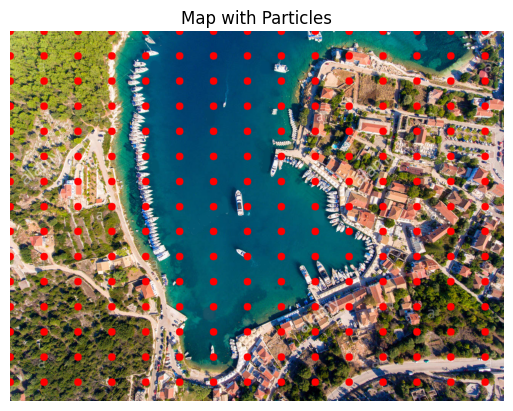

In [32]:
# Particle filter implementation
# Re-initialize map
dispmap = map.copy()

N = 15 #N*N particles, subject to change

# Generate a set P of N particles, uniformly distributed across the map 
x = np.linspace(0,map.shape[1]-dFOV,N)
y = np.linspace(0,map.shape[0]-dFOV,N)
# print(x)
# print(y)
particlePosArr = np.zeros([N**2,3]) #particle number, xpos, ypos

particleCount = 0
for i in x:
    for j in y:
        particlePosArr[particleCount,:] = [particleCount, i, j]
        
        # Draw the particle on the map image
        cv2.circle(dispmap, (int(i), int(j)), 10, (255, 0, 0), -1)  # Red circles for particles
        
        particleCount += 1

print(particlePosArr.shape)
# print(particlePosArr[:,1])

# Display the map with particles
plt.imshow(dispmap)
plt.title('Map with Particles')
plt.axis('off')  # Turn off the axis
plt.show()


In [34]:
# Set number of iterations to use with particle fiter 

iterations = 5
max_pixel_value = 255
num_pixels = true_pos.size  # total number of pixels
max_error = max_pixel_value * num_pixels/2

# Loop through each iteration 
for i in range(5):
    errors = []
    # First, create an image for each particle 
    for i in range(len(particlePosArr)):
        x = int(particlePosArr[i,1])
        y = int(particlePosArr[i,2])
        par_im = map[y:y+m,x:x+m]
        # Compare image to true position 
        diff = cv2.absdiff(ini_pos, par_im) # USING ABSOLUTE DIFEFRENCE
        error = np.sum(diff) # Sum the errors
        # print(error)
        # # Normalize the error
        # error_norm = error/max_error
        # print(error_norm)
        errors.append(error)
    weights = np.array(errors)
    epsilon = 1e-10
    weights_i = 1 / (weights + epsilon)
    # print(weights_i)
    weights_i_n = weights_i / np.sum(weights_i)
    # print(weights_i_n)
    # Resample particles
    num_particles = len(weights)
    indices = np.random.choice(range(num_particles), size=num_particles, p=normalized_inverted_weights)
    
    # Select the particles that correspond to the resampled indices
    resampled_particles = particlePosArr[indices]
    map_with_particles = map.copy()

    for i, particle in enumerate(resampled_particles):
        x = int(particle[1])  # x position
        y = int(particle[2])  # y position
        # size = int(weights_i_n[i])  # Scale for visibility; you can adjust this
        cv2.circle(map_with_particles, (x, y), 10, (255, 0, 0), -1)  # Draw filled circle in red
    
    
    plt.imshow(map_with_particles)
    
    # Scatter plot the particle positions
    # plt.scatter(resampled_particles[:, 1], resampled_particles[:, 2], color='red', marker='o', label='Particles')
    plt.show()

NameError: name 'true_pos' is not defined